In [1]:
'''
This python program implements the algorithm proposed in section 3 of the article "On using Deep Reinforcement Learning to balance
Power Consumption and latency100_10_0_20 in 5G NR" in which is an optimization algorithm to derive the best C-DRX parameters and Bandwitch Part
(BWP) configuration while guaranteeing a low Power Comsuption (PC) and avoiding the latency100_10_0_20 overflow
'''

import random as rd
import pandas as pd
from scipy.optimize import minimize
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt

# K UEs
#UEs = []
UEs = {}
UEsAux = []
# UEs = [ue0, ue1]
#ue0 = [[dij], [fij], [gij], [wij]]

#----- C-DRX Parameters -----

T = [10*x for x in range(0, 40)]


# available bandwidth
W = 2500000  #2.5 GHz

# Subcarrier spacing
sp = 692.5  #692.5 KHz

# Frequency of one PRB
fp = 180  #180 KHz

# Total number of PRBs
prbs = int((W - (2*sp))//fp)


# URLLC DRX possible configurations

deltaU = [2, 3, 4, 5, 6, 7, 8, 10, 14, 16, 20, 30, 32, 35, 40, 64, 80, 128, 160,
          256, 320, 512, 640]  # Set of Cycle Lenghts
fiU = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500,
       600, 800, 1000, 1200, 1600]  # Set of ON periods

dictU = {key: [] for key in deltaU}
for deltai in dictU.keys():
  for onL in fiU:
    if ((onL + int(0.5*onL)) <= deltai) and (deltai - onL + int(0.5*onL)) <= 5:
      dictU[deltai].append(onL)

aux = []
for key, value in dictU.items():
  if len(value) == 0:
    aux.append(key)

for key in aux:
  dictU.pop(key)


omegaU = [25000, 30000, 40000, 50000]  #MHz

# eMBB DRX possible configurations
deltaE = [10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280,
          2048, 2560, 5120, 10240]
fiE = [1, 2, 3, 4, 5, 6, 8, 10, 20, 30, 40, 50, 60, 80, 100, 200, 300, 400, 500,
       600, 800, 1000, 1200, 1600]
gamaE = [0, 10, 20, 32, 40, 60, 64, 70, 80, 128, 160, 256, 320, 512, 640, 1024, 1280,
         2048, 2560, 5120, 10240]


dictE = {key:{} for key in deltaE}
for deltai in dictE.keys():
  for onL in fiE:
    if onL <= deltai:
      dictE[deltai][onL] = []
      for offL in gamaE:
        if (offL + onL) <= deltai:
          dictE[deltai][onL].append(offL)

omegaE = [5000, 10000, 15000, 20000, 25000, 30000]  #MHz


# Posssible Cell_Sites
c = [1, 2]

# Power Comsuption
Pit = []
Pmax = 80


# Delay constraint URLLC
Limax = 4  #4ms
Lit = []

beta = []

In [2]:
def adiciona(estatico, x):
  if estatico == 1:  # pior caso URLLC (Cycle Length = 20ms; onTime = 1ms; offset = 2ms)
    dij = list(x[0:len(dictU.keys())])
    if dij.count(1) == 0:
      randindex = rd.randint(0, len(dictU.keys()) - 1)
      dij[randindex] = 1

    deltai = deltaU[dij.index(1)]

    onsP = dictU[deltai]
    fij = list(x[23: len(onsP) + 23])
    if fij.count(1) == 0:
      randindex = rd.randint(0, len(onsP) - 1)
      fij[randindex] = 1

    onA = onsP[fij.index(1)]

    wij = list(x[47:51])
    cij = list(x[51:53])
    soma = 0

    UEsAux.append({"Usuário": "URLLC", "Cycle Length [ms]": deltai, "onTime [ms]": onA,
                   "offset [ms]": int(0.5*onA), "BWP [MHz]": omegaU[wij.index(1)], "Packet Size [bytes]": 360,
                   "Cell_Site": rd.randint(1, 2)})

    soma += 50
    b = 0.4 + (0.6*((soma - 20)/80))
    beta.append(b)

  elif estatico == 2:
    dij = list(x[53:73])
    deltai = deltaE[dij.index(1)]
    dictdi = dictE[deltai]
    onsP = list(dictdi.keys())
    fij = list(x[73: len(onsP) + 73])
    if fij.count(1) == 0:
      randindex = rd.randint(0, len(onsP) - 1)
      fij[randindex] = 1

    onA = onsP[fij.index(1)]

    offsP = dictdi[onA]

    gij = list(x[103: len(offsP) + 103])
    if gij.count(1) == 0:
      randindex = rd.randint(0, len(offsP) - 1)
      gij[randindex] = 1

    offA = offsP[gij.index(1)]

    wij = list(x[123:129])
    cij = list(x[129:131])
    soma = 0

    UEsAux.append({"Usuário": "eMBB", "Cycle Length [ms]": deltai, "onTime [ms]": onA,
                   "offset [ms]": offA, "BWP [MHz]": omegaE[wij.index(1)], "Packet Size [bytes]": 6516,
                   "Cell_Site": rd.randint(1, 2)})

    soma += 20
    b = 0.4 + (0.6*((soma - 20)/80))
    beta.append(b)

In [3]:
def inicializaUE():
  keys = UEsAux[0].keys()
  UEs = {key:[] for key in keys}


  for ue in UEsAux:
    for keys2, values in ue.items():
      UEs[keys2].append(values)

  df = pd.DataFrame(UEs)
  return df

In [4]:
def offLs(df):
  #offLs = np.array(df['offset [ms]'])
  #return offLs
  pass

In [5]:
def offsets_(cycles):
  offsetsTimes = []

  for cycle in cycles:
    qtdCycle = 400/cycle
    aux = []
    i = 0
    while i <= qtdCycle:
      aux.append(cycle * i)
      i += 1

    offsetsTimes.append(aux)

  return offsetsTimes

In [6]:
def onTimes_(offs, cycles):
  onTimes = []
  for offL, cycle in zip(offs, cycles):
    qtdCycle = 400/cycle
    aux = [offL]
    i = 1
    while i <= qtdCycle:
      aux.append(aux[0] + (cycle * i))
      i += 1

    onTimes.append(aux)

  return onTimes

In [7]:
def inTimes_(cycles, onLs, offs):
  in_ = []
  for cycle, onL, offL in zip(cycles, onLs, offs):
    qtdCycle = 400/cycle

    aux = [(offL + onL + 1)]

    i = 1
    while i <= qtdCycle:
      aux.append(aux[0] + (cycle* i))
      i += 1

    in_.append(aux)

  return in_

Para cada usuário, haverá a lista de ins, ons e offs, para poder calcular as latências

In [8]:
def scheduler(df):
  df = df.sort_values(by = 'Cell_Site', ascending = True)
  df1 = df.query("Cell_Site == 1")
  df2 = df.query("Cell_Site == 2")
  snirUE1 = np.array([])
  snirUE2 = np.array([])
  k = 0
  prbs = 0
  for row1 in df1.itertuples():
    bwp1 = row1[5]
    if bwp1 == 5000:
      prbs = 25
      k = 1
    elif bwp1 == 10000:
      prbs = 52
      k = 2
    elif bwp1 == 15000:
      prbs = 79
      k = 3
    elif bwp1 == 20000:
      prbs = 106
      k = 4
    elif bwp1 == 25000:
      prbs = 133
      k = 5
    elif bwp1 == 30000:
      prbs = 160
      k = 6
    elif bwp1 == 40000:
      prbs = 216
      k = 8
    elif bwp1 == 50000:
      prbs = 270
      k = 10

    gains1 = np.random.rayleigh(scale = 1, size = (prbs//k))
    pBlocks1 = np.array(rd.choices(range(10, 30), weights=range(10, 30), k = (prbs//k)))
    signal1 = np.sum(gains1*pBlocks1)

    sliceType1 = row1[1]
    interference = np.array([])
    for row2 in df2.itertuples():
      sliceType2 = row2[1]
      bwp2 = row2[5]
      if (sliceType1 == sliceType2) and (bwp1 == bwp2):
        gains2 = np.random.rayleigh(scale = 1, size = (prbs//k))
        pBlocks2 = np.array(rd.choices(range(10, 30), weights = range(10, 30), k = (prbs//k)))
        signal2 = np.sum(gains2*pBlocks2)

        interference = np.append(interference, signal2)

    totalInterferenceUe = np.sum(interference)
    snirUE = signal1/(totalInterferenceUe + 114)
    snirUE1 = np.append(snirUE1, snirUE)

  for row2 in df2.itertuples():
    bwp2 = row2[5]
    if bwp2 == 5000:
      prbs = 25
      k = 1
    elif bwp2 == 10000:
      prbs = 52
      k = 2
    elif bwp2 == 15000:
      prbs = 79
      k = 3
    elif bwp2 == 20000:
      prbs = 106
      k = 4
    elif bwp2 == 25000:
      prbs = 133
      k = 5
    elif bwp2 == 30000:
      prbs = 160
      k = 6
    elif bwp2 == 40000:
      prbs = 216
      k = 8
    elif bwp2 == 50000:
      prbs = 270
      k = 10

    gains2 = np.random.rayleigh(scale = 1, size = (prbs//k))
    pBlocks2 = np.array(rd.choices(range(10, 30), weights = range(10, 30), k = (prbs//k)))
    signal2 = np.sum(gains2*pBlocks2)

    sliceType2 = row2[1]
    interference = np.array([])
    for row1 in df1.itertuples():
      sliceType1 = row1[1]
      bwp1 = row1[5]
      if (sliceType1 == sliceType2) and (bwp1 == bwp2):
        gains1 = np.random.rayleigh(scale = 1, size = (prbs//k))
        pBlocks1 = np.array(rd.choices(range(10, 30), weights = range(10, 30), k = (prbs//k)))
        signal1 = np.sum(gains1*pBlocks1)

        interference = np.append(interference, signal1)

    totalInterferenceUe = np.sum(interference)
    snirUE = signal2/(totalInterferenceUe + 114)
    snirUE2 = np.append(snirUE2, snirUE)

  SNIR = np.concatenate((snirUE1, snirUE2))
  SNIRlist = SNIR.tolist()
  df.loc[:, 'SNIR'] = SNIRlist
  return df


In [9]:
import math
def shannonCapacity(df):
  snirs = list(df['SNIR'])
  bwps = list(df['BWP [MHz]'])
  shannonCapacity = []

  for bwp, snirUE in zip(bwps, snirs):
    capacity = bwp*math.log2(1 + snirUE)

    shannonCapacity.append(capacity)

  df['Shannon Capacity'] = shannonCapacity
  #print(df)
  return df


In [10]:
def timeOff(offs, ons, tcs):
  taO = []
  aux = []

  for tc2 in tcs:
    for off, on in zip(offs, ons):
      if offs[0] == ons[0]:
        aux.append(0)

      elif tc2 in range(off, on):
        aux.append(on - tc2)
      else:
        aux.append(0)

    taO.append(sum(aux))
    aux.clear()

  return np.array(taO)

In [11]:
def timeIn(offs, ons, ins, tcs, onL, cycle):
  aux = []
  taI = []
  for tc2 in tcs:
    for inn, off, on in zip(ins, offs, ons):
      if (tc2 in range(inn, (off + cycle + 1))):
        if cycle == onL:
          aux.append(0)
        else:
          aux.append((on + cycle) - tc2)
      else:
        aux.append(0)

    taI.append(sum(aux))
    aux.clear()

  return np.array(taI)

In [12]:
from scipy.stats import poisson

In [13]:
def arrivalTimePoisson():
  mean_rate = 1//5
  qtds = [y for y in range(1, 401)]
  probability = poisson.pmf(qtds, mean_rate)
  aux = {}

  for qtd, prob in zip(qtds, probability):
    aux[qtd] = prob

  values = []
  values.extend(aux.values())
  maxProb = max(values)
  for chave in aux.keys():
    if aux[chave] == maxProb:
      qtdMax = chave

  period = 400//qtdMax
  tc = [timeA for timeA in range(0, 401, period)]
  return tc

In [14]:
def latencyCycle(df, tc):
  cycles = np.array(df['Cycle Length [ms]'])
  offLs = np.array(df['offset [ms]'])
  onLs = np.array(df['onTime [ms]'])
  inTimes = inTimes_(cycles, onLs, offLs)
  offsets = offsets_(cycles)
  onTimes = onTimes_(offLs, cycles)

  Lc = []
  for on, off, in_ in zip(onTimes, offsets, inTimes):
    onLUE = onLs[onTimes.index(on)]
    cycleUE = cycles[onTimes.index(on)]

    taI = timeIn(off, on, in_, tc, onLUE, cycleUE)
    taO = timeOff(off, on, tc)
    latencyCycle = taI + taO
    Lc.append(latencyCycle.tolist())

  df['Latency_Cycle'] = Lc
  #print(df)
  return df

In [15]:
from itertools import cycle
def DCI(df, tcs):
  kmax = []

  bwps = np.array(df['BWP [MHz]'])

  onL = np.array(df['onTime [ms]'])

  cycle = np.array(df['Cycle Length [ms]'])

  for bwp in bwps:
    if bwp == 25000:
      kmax.append(5)
    elif bwp == 30000:
      kmax.append(6)
    elif bwp == 40000:
      kmax.append(8)
    elif bwp == 20000:
      kmax.append(4)
    elif bwp == 5000:
      kmax.append(1)
    elif bwp == 10000:
      kmax.append(2)
    elif bwp == 15000:
      kmax.append(3)
    elif bwp == 50000:
      kmax.append(10)


  auxx = [0]*len(tcs)
  aux1 = [auxx]*len(kmax)
  for tc in range(len(tcs)):
    auxList = []
    for k in kmax:
      if kmax.index(k) not in auxList:
        indexes = [kmax.index(k)]
        for k2 in kmax[kmax.index(k):]:
          if k2 == k:
            indexes.append(kmax.index(k2))

      auxList.extend(indexes)
      qtdGroup = onL[indexes[0]]//k
      for ue in indexes:
        group = 0
        kaux = 0
        if aux1[ue][tc] == 0:
          aux1[ue][tc] = 0
          sample = rd.sample(indexes, k)
          while (ue not in sample):
            group += 1
            aux1[ue][tc] += 1
            for ue2 in sample:
              if group > qtdGroup and group % qtdGroup == 0:
                kaux = 0

              if group < qtdGroup:
                if kaux < k:
                  aux1[ue2][tc] += 1
                elif kaux >= k and kaux < 2*k:
                  aux1[ue2][tc] += 2
                elif kaux >= 2*k and kaux < 3*k:
                  aux1[ue2][tc] += 3
                elif kaux >= 3*k and kaux < 4*k:
                  aux1[ue2][tc] += 4
                elif kaux >= 4*k and kaux < 5*k:
                  aux1[ue2][tc] += 5
                elif kaux >= 5*k and kaux < 6*k:
                  aux1[ue2][tc] += 6

                kaux += 1
              elif group >= qtdGroup and group < 2* qtdGroup:
                if kaux < k:
                  aux1[ue2][tc] = cycle[ue2]
                elif kaux >= k and kaux < 2*k:
                  aux1[ue2][tc] = cycle[ue2] + 1
                elif kaux >= 2*k and kaux < 3*k:
                  aux1[ue2][tc] = cycle[ue2] + 2
                elif kaux >= 3*k and kaux < 4*k:
                  aux1[ue2][tc] = cycle[ue2] + 3
                elif kaux >= 4*k and kaux < 5*k:
                  aux1[ue2][tc] = cycle[ue2] + 4
                elif kaux >= 5*k and kaux < 6*k:
                  aux1[ue2][tc] = cycle[ue2] + 5
                elif kaux >= 6*k and kaux < 7*k:
                  aux1[ue2][tc] = cycle[ue2] + 6

                kaux += 1
              elif group >= 2*qtdGroup and group < 3*qtdGroup:
                if kaux < k:
                  aux1[ue2][tc] = 2*cycle[ue2]
                elif kaux >= k and kaux < 2*k:
                  aux1[ue2][tc] = 2*cycle[ue2] + 1
                elif kaux >= 2*k and kaux < 3*k:
                  aux1[ue2][tc] = 2*cycle[ue2] + 2
                elif kaux >= 3*k and kaux < 4*k:
                  aux1[ue2][tc] = 2*cycle[ue2] + 3
                elif kaux >= 4*k and kaux < 5*k:
                  aux1[ue2][tc] = 2*cycle[ue2] + 4
                elif kaux >= 5*k and kaux < 6*k:
                  aux1[ue2][tc] = 2*cycle[ue2] + 5
                elif kaux >= 6*k and kaux < 7*k:
                  aux1[ue2][tc] = 2*cycle[ue2] + 6

                kaux += 1
              elif group >= 3*qtdGroup:
                if kaux < k:
                  aux1[ue2][tc] = 3*cycle[ue2]
                elif kaux >= k and kaux < 2*k:
                  aux1[ue2][tc] = 3*cycle[ue2] + 1
                elif kaux >= 2*k and kaux < 3*k:
                  aux1[ue2][tc] = 3*cycle[ue2] + 2
                elif kaux >= 3*k and kaux < 4*k:
                  aux1[ue2][tc] = 3*cycle[ue2] + 3
                elif kaux >= 4*k and kaux < 5*k:
                  aux1[ue2][tc] = 3*cycle[ue2] + 4
                elif kaux >= 5*k and kaux < 6*k:
                  aux1[ue2][tc] = 3*cycle[ue2] + 5
                elif kaux >= 6*k and kaux < 7*k:
                  aux1[ue2][tc] = 3*cycle[ue2] + 6

                kaux += 1

            sample = rd.sample(indexes, k)


  df['DCI_time'] = aux1
  return df

In [16]:
def transmissionTime(df, tcs):
  sizes = np.array(df['Packet Size [bytes]'])
  capacities = np.array(df['Shannon Capacity'])
  tT = []

  for size, capacity in zip(sizes, capacities):
    aux = []
    for tc in tcs:
      aux.append(size/capacity)  #196.08 bytes/ms = 196608 bytes/s = 1.5mbs
    tT.append(aux)

  df['Transmission_time'] = tT

  return df

In [17]:
def totalLatency(df):
  latencyaux = list(df['Latency_Cycle'])
  tTaux = list(df['Transmission_time'])
  dciaux = list(df['DCI_time'])

  latencyCycle = np.array(latencyaux)
  dci = np.array(dciaux)
  tT = np.array(tTaux)

  totalLatencyaux = latencyCycle + dci
  totalLatency = totalLatencyaux + tT
  df['Total_Latency'] = totalLatency.tolist()
  #print(df)
  return df

In [18]:
def power(df):
  p = []
  onLs = np.array(df['onTime [ms]'])
  cycles = np.array(df['Cycle Length [ms]'])
  offLs = np.array(df['offset [ms]'])
  onTimes = onTimes_(offLs, cycles)
  for ons in onTimes:
    onLUE = onLs[onTimes.index(ons)]
    for oni in ons:
      for i in range(onLUE):
        p.append(1)

    Pit.append(sum(p))

In [19]:
def lista_simples(lista):
  if isinstance(lista, list):
      return [sub_elem for elem in lista for sub_elem in lista_simples(elem)]
  else:
      return [lista]

In [20]:
def objectiveFunction(x, nURLLC, nEMBB):
  # x[0] = variável para otimizar a latência em função do omega
  # x[1] = variável para calcular a quantidade de ciclo ON

  #qtdCy = 400
  #tcx = int(x[0])
  #tc = [tcx for tcx in range (tcx, qtdCy, tcx)]
  tc = arrivalTimePoisson()

  UEs.clear()
  UEsAux.clear()
  if nURLLC > nEMBB:
    for i in range(0, (nURLLC + nEMBB)):
      if i < nEMBB:
        adiciona(2, x)
      else:
        adiciona(1, x)
  elif nURLLC < nEMBB:
    for i in range(0, (nURLLC + nEMBB)):
      if i < nURLLC:
        adiciona(1, x)
      else:
        adiciona(2, x)

  df = inicializaUE()
  df = scheduler(df)
  df = shannonCapacity(df)
  df = latencyCycle(df, tc)
  df = DCI(df, tc)
  df = transmissionTime(df, tc)
  df = totalLatency(df)
  #print(df)
  latency = (np.array(df['Total_Latency']))
  auxlist = []
  auxlist.append(latency.tolist())
  Lit.extend(lista_simples(auxlist))
  power(df)


  sum2 = 0


  for i in range(0, len(UEs)):
      sum1 = 0
      sum2 = 0
      for j in range(0, len(T)):
          aux = (beta[i] * Pit[i])/ Pmax
          sum1 += aux

      sum2 += sum1
  return sum2


#restricoes
def restricao(x):
  sum1 = sum(x[0:23])
  sum2 = sum(x[23:47])
  sum3 = sum(x[47:51])
  sum4 = sum(x[51:53])
  sum5 = sum(x[53:73])
  sum6 = sum(x[73:123])
  sum7 = sum(x[123:129])
  sum8 = sum(x[129:131])
  return (sum1 + sum2 + sum3 + sum4 + sum5 + sum6 + sum7 + sum8 - 8)

cons = [{'type': 'ineq', 'fun': restricao}]


# limites
#a = [10, 20, 50, 100, 200]
#a = [5, 10, 20, 50, 100]
#b = [1000, 100000]  # Valores possíveis de wij

a = tuple(131*[[0, 1]])


bnds = a



In [21]:
from time import time

In [22]:
# estimativa inicial
x0 = 131*[1]

#Vetores para guardar a latência em cada caso
latency_20_80 = []
latency_40_60 = []
latency_60_40 = []
latency_80_20 = []

#Vetores para guardar a quantidade de usuários na rede

#Vetores para guardar a potência em cada caso
power_20_80 = []
power_40_60 = []
power_60_40 = []
power_80_20 = []

NURLLC = 20
NeMBB = 80

tempo = 4
start = time()
while (time() - start) <= tempo:

  solution = minimize(objectiveFunction, x0, method='SLSQP', bounds=bnds, constraints=cons, args=(NURLLC, NeMBB))
  latency_20_80.extend(Lit)
  power_20_80.extend(Pit)

Lit.clear()
Pit.clear()
UEs.clear()

In [23]:
NURLLC = 40
NeMBB = 60

tempo = 4
start = time()
while (time() - start) <= tempo:

  solution = minimize(objectiveFunction, x0, method='SLSQP', bounds=bnds, constraints=cons, args=(NURLLC, NeMBB))
  latency_40_60.extend(Lit)
  power_40_60.extend(Pit)


Lit.clear()
Pit.clear()
UEs.clear()

In [24]:
NURLLC = 60
NeMBB = 40

tempo = 4
start = time()
while (time() - start) <= tempo:

  solution = minimize(objectiveFunction, x0, method='SLSQP', bounds=bnds, constraints=cons, args=(NURLLC, NeMBB))
  latency_60_40.extend(Lit)
  power_60_40.extend(Pit)


Lit.clear()
Pit.clear()
UEs.clear()

In [25]:
NURLLC = 80
NeMBB = 20

tempo = 4
start = time()
while (time() - start) <= tempo:

  solution = minimize(objectiveFunction, x0, method='SLSQP', bounds=bnds, constraints=cons, args=(NURLLC, NeMBB))
  latency_80_20.extend(Lit)
  power_80_20.extend(Pit)


Lit.clear()
Pit.clear()
UEs.clear()

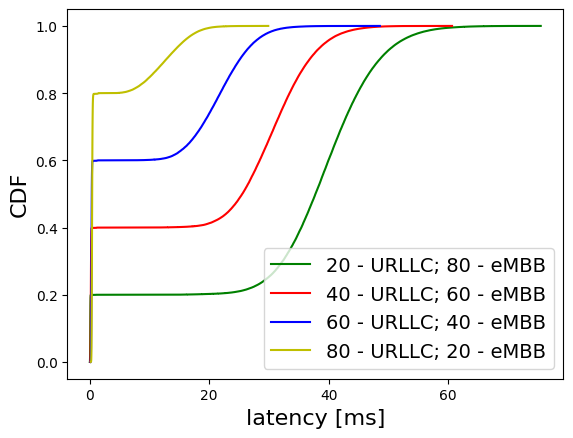

In [26]:
sortL = np.sort(latency_20_80)
sortL2 = np.sort(latency_40_60)
sortL3 =  np.sort(latency_60_40)
sortL4 = np.sort(latency_80_20)

pL = 1.0 * np.arange(len(sortL)) / float(len(sortL) - 1)
pL2 = 1.0 * np.arange(len(sortL2)) / float(len(sortL2) - 1)
pL3 = 1.0 * np.arange(len(sortL3)) / float(len(sortL3) - 1)
pL4 = 1.0 * np.arange(len(sortL4)) / float(len(sortL4) - 1)

plt.plot(sortL, pL, "-g", label="20 - URLLC; 80 - eMBB")
plt.plot(sortL2, pL2, "-r", label="40 - URLLC; 60 - eMBB")
plt.plot(sortL3, pL3, "-b", label="60 - URLLC; 40 - eMBB")
plt.plot(sortL4, pL4, "-y", label="80 - URLLC; 20 - eMBB")
plt.legend(loc="lower right", fontsize=14)
plt.xlabel('latency [ms]', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.show()

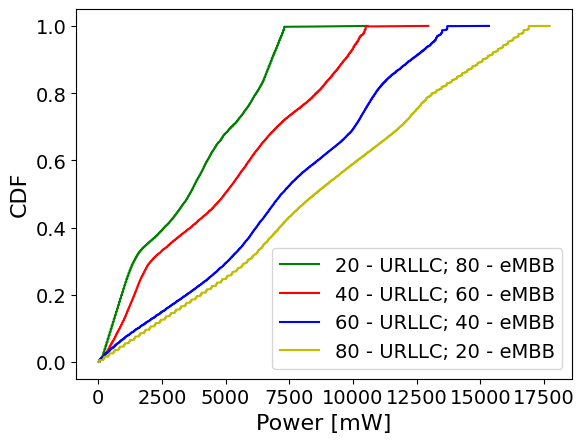

In [27]:
sortL = np.sort(power_20_80)
sortL2 = np.sort(power_40_60)
sortL3 =  np.sort(power_60_40)
sortL4 = np.sort(power_80_20)

pL = 1.0 * np.arange(len(sortL)) / float(len(sortL) - 1)
pL2 = 1.0 * np.arange(len(sortL2)) / float(len(sortL2) - 1)
pL3 = 1.0 * np.arange(len(sortL3)) / float(len(sortL3) - 1)
pL4 = 1.0 * np.arange(len(sortL4)) / float(len(sortL4) - 1)

plt.plot(sortL, pL, "-g", label="20 - URLLC; 80 - eMBB")
plt.plot(sortL2, pL2, "-r", label="40 - URLLC; 60 - eMBB")
plt.plot(sortL3, pL3, "-b", label="60 - URLLC; 40 - eMBB")
plt.plot(sortL4, pL4, "-y", label="80 - URLLC; 20 - eMBB")
plt.legend(loc="lower right", fontsize=14)
plt.xlabel('Power [mW]', fontsize=16)
plt.ylabel('CDF', fontsize=16)
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14
plt.show()